<a href="https://colab.research.google.com/github/Umaporn19/Project/blob/main/(Test_Damage_600_epochs_freeze).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np

In [3]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1067, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 1067 (delta 114), reused 161 (delta 79), pack-reused 837
Receiving objects: 100% (1067/1067), 13.93 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (611/611), done.
/content/efficientnet_keras_transfer_learning


In [26]:
df = pd.read_csv (r'/content/drive/MyDrive/Newdata/TTest_Damage.csv')
df

,Unnamed: 0,Path_Name,Degree
0,0,/content/drive/My Drive/id/id2/Base/p11/dis1.7...,Base
1,1,/content/drive/My Drive/id/id2/Base/p11/dis1.7...,Base
2,2,/content/drive/My Drive/id/id2/Base/p11/dis1.7...,Base
3,3,/content/drive/My Drive/id/id2/Base/p11/dis1.7...,Base
4,4,/content/drive/My Drive/id/id2/Base/p11/dis1.7...,Base
...,...,...,...
244350,244350,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244351,244351,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244352,244352,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244353,244353,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Model/600_(damage)_Train_id2_id6_id8_id10_Test_id12.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [6]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Model/600_(damage)_Train_id2_id6_id8_id10_Test_id12.h5')
height = width = model.input_shape[1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
DATA_PATH = "/content/drive/My Drive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/My Drive/id/train
/content/drive/My Drive/id/test


In [8]:
train = df[df['Unnamed: 0'].between(0,243527)]
test = df[df['Unnamed: 0'].between(243528,244354)]

In [9]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Degree',
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
        

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 243528 validated image filenames belonging to 4 classes.
{0: 'Base', 1: 'Minor', 2: 'Moderate', 3: 'Severe'}


In [27]:
test = df[df['Unnamed: 0'].between(243528,244354)]
test

,Unnamed: 0,Path_Name,Degree
243528,243528,/content/drive/My Drive/Dataset_CDD_v4/trainin...,Severe
243529,243529,/content/drive/My Drive/Dataset_CDD_v4/trainin...,Severe
243530,243530,/content/drive/My Drive/Dataset_CDD_v4/trainin...,Severe
243531,243531,/content/drive/My Drive/Dataset_CDD_v4/trainin...,Severe
243532,243532,/content/drive/My Drive/Dataset_CDD_v4/trainin...,Severe
...,...,...,...
244350,244350,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244351,244351,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244352,244352,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe
244353,244353,/content/drive/My Drive/Dataset_CDD_v4/validat...,Severe


In [28]:
act = test['Degree'].tolist() #ค่าจริง
path = test['Path_Name'].tolist() #path

In [29]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path): #สร้างฟังก์ชัน 
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width)) #รูปทุกรูปมีขนาดไม่เท่ากันจึงตั้งไว้ว่าเวลาจะให้ model ดึงรูปมาทำนายให้ดึงรูปเข้ามาตามขนาดที่ตั้งไว้ตาม พารามิตเตอร์
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img) # model ไม่สามารถทำนายรูปภาพโดยตรงได้ จึงเเปลงรูปภาพให้เป็น array เเล้วให้โมเดลทำนาย
    # Reshape
    x = x.reshape((1,) + x.shape) # เพิ่ม ไดเมนชั่นของโมเดล ให้เป็น 4 ได้ เมนชั่น โดยที่ 1, คือบอกให้โมเดลนำเข้าทีละ 1 รูปเเล้วค่อยทำนาย เเละ + ไดเมนชั่น คือ 150 ,150 ,3(สีของ RGB)
    x /= 255.
    result = model.predict([x])
    return result[0]

In [36]:
predict_image(path[0])[0]

1/1 [==============================] - 10s 10s/step


0.0021366207

In [37]:
import numpy as np

In [38]:
#Predict
pred_list = list()
prob_list = list()
img_path= path
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

1/1 [==============================] - 0s 29ms/step


In [39]:
pred_list

['Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Base',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Base',
 'Severe',
 'Severe',
 'Severe',
 

In [40]:
pred = np.array(pred_list)
act = np.array(act)

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 47.88391777509069%
              precision    recall  f1-score   support

        Base       0.00      0.00      0.00         0
       Minor       0.36      0.03      0.06       144
    Moderate       0.00      0.00      0.00       238
      Severe       0.62      0.88      0.72       445

    accuracy                           0.48       827
   macro avg       0.24      0.23      0.20       827
weighted avg       0.39      0.48      0.40       827



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

Text(0.5, 66.5, 'Predicted label')

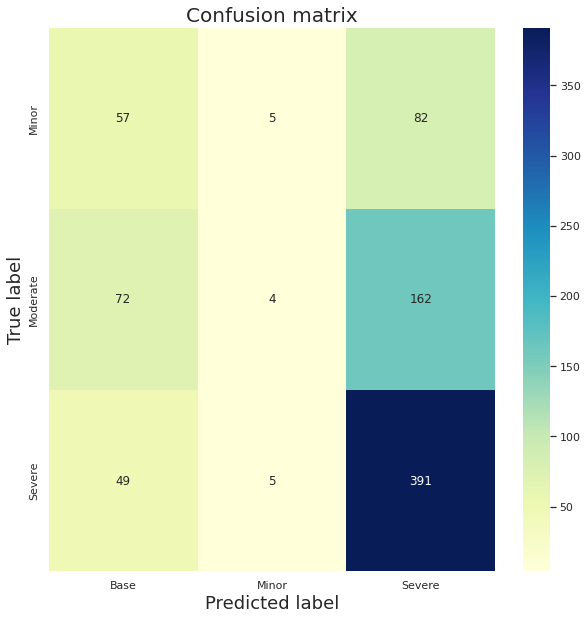

In [42]:
#create CF 
data = {'Actual': act,'Predicted' : pred}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)